In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchmetrics import Accuracy

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as f_vision

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [18]:
transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder(root='./data', transform=transform)
test_dataset = datasets.ImageFolder(root='./data', transform=transform)

In [19]:
#Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

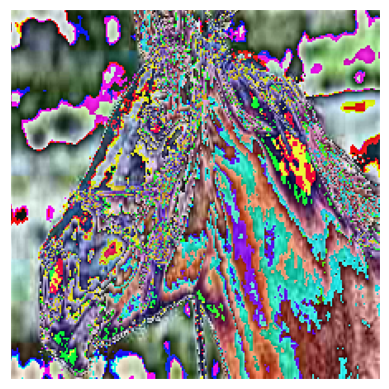

In [20]:
#check dataloader

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = f_vision.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


for x_train, y_train in train_loader:
    break

show(x_train[0])

In [87]:
def conv_depthwise(inp, oup, stride):
    return nn.Sequential(
        # dw
        nn.Conv2d(inp, inp, kernel_size=3, stride=stride, padding=1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.ReLU(inplace=True),

        # pw
        nn.Conv2d(inp, oup, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True),
)


class MobileNet(nn.Module):
    def __init__(self, inp_channels: int, num_classes: int):
        super().__init__()

        self.input_layer = nn.Sequential(nn.Conv2d(in_channels=inp_channels, out_channels=32, kernel_size=3, padding=1, stride=2, bias=False),
                                         nn.ReLU(inplace=True),
                                         nn.BatchNorm2d(32))

        self.features = nn.Sequential(conv_depthwise(inp=32, oup=64, stride=1),
                                      conv_depthwise(inp=64, oup=128, stride=2),
                                      conv_depthwise(inp=128, oup=128, stride=1),
                                      conv_depthwise(inp=128, oup=256, stride=2),
                                      conv_depthwise(inp=256, oup=256, stride=1),
                                      conv_depthwise(inp=256, oup=512, stride=2),
                                      conv_depthwise(inp=512, oup=512, stride=1),
                                      conv_depthwise(inp=512, oup=512, stride=1),
                                      conv_depthwise(inp=512, oup=512, stride=1),
                                      conv_depthwise(inp=512, oup=512, stride=1),
                                      conv_depthwise(inp=512, oup=512, stride=1),
                                      conv_depthwise(inp=512, oup=1024, stride=2),
                                      conv_depthwise(inp=1024, oup=1024, stride=1))

        self.avg1 = nn.AvgPool2d(kernel_size=1)
        self.fc1 = nn.Linear(in_features=1024*7*7, out_features=num_classes)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        x = self.input_layer(x)
        x = self.features(x)
        x = self.avg1(x)
        x = x.view(-1, 1024*7*7)
        x = self.fc1(x)
        return self.softmax(x)